In [1]:
!pip install implicit

     |████████████████████████████████| 1.1MB 13.3MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406407 sha256=46dbed64ddbc1e230ab313ed1cc00e36a85fe935358127159986fc5c3486c5f3
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [134]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

Это означает, что weight = np(log(sales_value.(sum))). Воспользуемся датафреймом popularity. 

In [76]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity

,item_id,sales_value
0,25671,20.94
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,1.98
...,...,...
89046,17991689,2.49
89047,17991691,2.49
89048,18000012,19.96
89049,18024155,3.99


In [77]:
#Сделаем самопроверку, правильно ли отработал код и действительно ли все просуммировалось

In [78]:
data[data.item_id == 18024556]   #все ок. Можно смело формировать веса по sales_value из таблицы выше. 

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2372461,2070,41587446572,658,18024556,1,10.17,311,0.0,1759,95,0.0,0.0
2382149,1797,41613955523,660,18024556,1,10.17,322,0.0,1329,95,0.0,0.0
2396105,2161,41653146075,663,18024556,1,10.17,369,0.0,1720,95,0.0,0.0


Натуральный логарифм от 0 будет равен -inf. Проверим сколько у нас таких товаров. 

In [79]:
popularity[popularity.sales_value == 0] 

,item_id,sales_value
140,30937,0.0
2508,142713,0.0
3561,410388,0.0
5256,744587,0.0
5918,821773,0.0
...,...,...
88691,17179257,0.0
88827,17240187,0.0
88920,17284401,0.0
88945,17291554,0.0


In [80]:
popularity['weight'] = popularity.sales_value.map(lambda x: np.log(x))
popularity.tail(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


,item_id,sales_value,weight
89046,17991689,2.49,0.912283
89047,17991691,2.49,0.912283
89048,18000012,19.96,2.993730
89049,18024155,3.99,1.383791
89050,18024556,30.51,3.418054


In [81]:
popularity['weight'] = popularity['weight'].replace(-np.inf, 0)

In [82]:
popularity.tail(5)

,item_id,sales_value,weight
89046,17991689,2.49,0.912283
89047,17991691,2.49,0.912283
89048,18000012,19.96,2.993730
89049,18024155,3.99,1.383791
89050,18024556,30.51,3.418054


In [83]:
# заменить все отрицательные веса на нули

In [84]:
popularity[popularity.weight < 0] 

,item_id,sales_value,weight
1,26081,0.99,-0.010050
20,27346,0.99,-0.010050
25,27509,0.88,-0.127833
26,27510,0.69,-0.371064
34,27697,0.89,-0.116534
...,...,...,...
88659,17170702,0.70,-0.356675
88859,17248297,0.99,-0.010050
88860,17248306,0.79,-0.235722
89013,17901795,0.50,-0.693147


In [85]:
popularity.loc[popularity['weight'] < 0, 'weight'] = 0

In [86]:
popularity['weight'] = popularity['sales_value']/np.sum(popularity['sales_value'])

In [87]:
popularity.head()

,item_id,sales_value,weight
0,25671,20.94,2.817523e-06
1,26081,0.99,1.332067e-07
2,26093,1.59,2.139380e-07
3,26190,1.54,2.072103e-07
4,26355,1.98,2.664133e-07


In [88]:
popularity['weight'].sum()

1.0

In [89]:
item_weights = popularity

In [90]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
        Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1"""
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    items = items_weights['item_id'].values
    weights = items_weights['weight'].values

    recs = np.random.choice(items, size=n, replace=False, p=weights)

    return recs.tolist()

In [91]:
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights=popularity, n=5))

In [92]:
# Переписываем бейзлайн с урока сюда для удобства. 

In [93]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [94]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [95]:
items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[5587974, 6554624, 9881657, 12672881, 984573]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[5791096, 9487750, 863070, 142934, 8357741]"


In [25]:
# для weighted-random-recommendation

In [96]:
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights=popularity, n=5))
result.head(2)

,user_id,actual,random_recommendation,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[5587974, 6554624, 9881657, 12672881, 984573]","[961791, 1046957, 854852, 823641, 935968]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[5791096, 9487750, 863070, 142934, 8357741]","[999730, 6534178, 944836, 864143, 1057231]"


## Задание 2. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая случаный на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [99]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [98]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [101]:
top_5000[:5]

[6534178, 6533889, 6534166, 6544236, 1404121]

In [102]:
data_train.head(100)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1060,26985040735,1,9553288,1,8.49,315,0.00,1251,1,0.0,0.0
96,1351,26985052379,1,903230,1,0.99,447,-0.30,1955,1,0.0,0.0
97,744,26985165432,1,5978648,0,0.00,31582,0.00,1119,1,0.0,0.0
98,212,26985205886,1,822346,1,1.25,288,-0.34,1341,1,0.0,0.0


In [103]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [104]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [127]:
data_train2 = data_train.loc[data_train['item_id'].isin(top_5000),] #теперь уже наоборот

In [128]:
data_train2.shape

(1448716, 12)

In [106]:
%%time

items = data_train.item_id.unique()
result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

CPU times: user 4 s, sys: 24.3 ms, total: 4.02 s
Wall time: 4.03 s


In [107]:
%%time

items = data_train2.item_id.unique()
result['random_recommendation_2'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

CPU times: user 261 ms, sys: 1.95 ms, total: 263 ms
Wall time: 265 ms


In [108]:
%%time

popular_recs = popularity_recommendation(data_train, n=5)
result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)

CPU times: user 111 ms, sys: 931 µs, total: 112 ms
Wall time: 112 ms


In [109]:
%%time

popular_recs = popularity_recommendation(data_train2, n=5)
result['popular_recommendation_2'] = result['user_id'].apply(lambda x: popular_recs)

CPU times: user 37.6 ms, sys: 0 ns, total: 37.6 ms
Wall time: 38.6 ms


In [111]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    precision = flags.sum() / len(recommended_list)
    return precision

In [113]:
#оценим точность предсказаний по метрике precision_at_5

In [112]:
pd.DataFrame([
    result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean(),
    result.apply(lambda row: precision_at_k(row['random_recommendation_2'], row['actual']), axis=1).mean(),
    result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean(),
    result.apply(lambda row: precision_at_k(row['popular_recommendation_2'], row['actual']), axis=1).mean(),
], 
    columns=['precision_at_k'], 
    index=['random_recommendation', 'random_recommendation_5к', 'popular_recommendation', 'popular_recommendation_5к']
).T

,random_recommendation,random_recommendation_5к,popular_recommendation,popular_recommendation_5к
precision_at_k,0.000196,0.00666,0.15524,0.15524


- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [115]:
# давайте сделаем перебор от 1 до 20 и посмотрим на результат. data_train оставляем прежний, в условии про это ничего не сказано. 

In [135]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()



In [136]:
user_item_matrix.shape

(2499, 86865)

In [138]:
# создаем словари мапинга между id бизнеса к строчному id матрицы

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [140]:
for k in range(1, 21):
    
    model = ItemItemRecommender(K=k, num_threads=4)  # K - кол-во билжайших соседей
    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
    
    recs = model.recommend(
        userid=userid_to_id[2],  # userid - id от 0 до N
        user_items=csr_matrix(user_item_matrix).tocsr(),  # на вход user-item matrix
        N=5,  # кол-во рекомендаций 
        filter_already_liked_items=False,
        filter_items=None,  #ничего не отфильтровываем
        recalculate_user=True)
    
    result[f'itemitem_K={k}'] = result['user_id'].\
        apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                        model.recommend(userid=userid_to_id[x], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=None, 
                                        recalculate_user=True)])

In [155]:
result_20_k = pd.DataFrame(
    [
        result.apply(lambda row: precision_at_k(row['itemitem_K=1'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=2'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=3'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=4'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=5'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=6'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=7'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=8'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=9'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=10'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=11'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=12'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=13'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=14'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=15'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=16'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=17'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=18'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=19'], row['actual']), axis=1).mean(),
        result.apply(lambda row: precision_at_k(row['itemitem_K=20'], row['actual']), axis=1).mean(),
    ], columns = ['precision_at_k'], index=[f'k={i}' for i in range(1, 21)])

In [156]:
result_20_k

,precision_at_k
k=1,0.219491
k=2,0.206268
k=3,0.170029
k=4,0.151028
k=5,0.154065
k=6,0.159060
k=7,0.164153
k=8,0.164643
k=9,0.166895
k=10,0.166993


In [160]:
from matplotlib import pyplot as plt

In [166]:
k = np.arange(1, 21)
result_20_k_v = result_20_k.precision_at_k.to_numpy()

In [167]:
result_20_k_v

array([0.2194907 , 0.20626836, 0.17002938, 0.1510284 , 0.15406464,
       0.15905975, 0.16415279, 0.16464251, 0.1668952 , 0.16699314,
       0.16699314, 0.16660137, 0.16630754, 0.1668952 , 0.16709109,
       0.16679726, 0.16699314, 0.16738492, 0.16728697, 0.16767875])

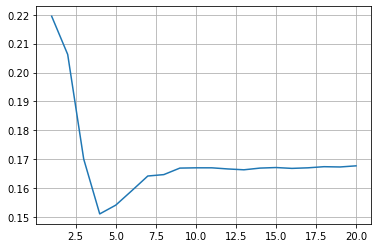

In [168]:
plt.plot(k, result_20_k_v)
plt.grid()
plt.show()

In [ ]:
# Вывод из графика: когда рекомендуешь сам себе (один сосед) - то получаем наилучшую рекомендательную систему.
# Но этот ложный факт должен скорее насторожить, чем поднять настроение. 
# Cчитаем, что при k=2 мы получили наилучшее значении precision_at_5